<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/PyTorch_Projects/blob/main/custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Steps to solve a machine learning problem:
1. Find a dataset
2. Turn the dataset into numbers
3. Create a model or find a pretrained one to extract the patterns in the data for prediction

# Intro

- Custom Data: a collection of data relating to your problem.
- PyTorch provides functions to load in different custom datasets in the **TorchVision**, **TorchText**, **TorchAudio**, and **TorchRec** domain libraries.
- If the previous functions are not enough, we can subclass **torch.utils.data.Dataset** and customize it to our needs.
- In this notebook, we will not use an in-built PyTorch dataset.
- We will load a custom dataset and train a model on it.



# Setting up environment

In [ ]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [ ]:
# Using a device-agnostic code is a best practice in DL

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Setting up Data

- Start with existing data.
- We will use a subset of the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.
- Food-101 splits to:
    - 1000 images of 101 different kinds of foods = 101,000 total images
    - 750,750 for training and 250,250 for testing
- Food-101 is included in PyTorch now.

## Formatting the custom data

- We will start with three food classes: Sushi, Pizza, and Steak.

### Data Creation

In [ ]:
# import torchvision as tv
# import pathlib # Setting up data directory

# tv.__version__
# data_dir = pathlib.Path("../data")

In [ ]:
# train_data = tv.datasets.Food101(root = data_dir,
#                          split = "train",
#                          download = True)

# test_data = tv.datasets.Food101(root = data_dir,
#                                 split = "test",
#                                 download = True)

In [ ]:
# train_data, test_data

In [ ]:
# class_names = train_data.classes
# print(len(class_names))
# class_names[:20]

In [ ]:
# # View a sample image

# print(class_names[train_data[1000][1]])
# train_data[1000][0]

### Subseting appropriate classes

- Copy 10% random images of the specified classes to a separate folders.

In [ ]:
# import random

In [ ]:
# data_path = data_dir / "food-101" / "images"
# target_classes = ["pizza", "steak", "sushi"]

# DATA_AMOUNT = 0.1

# def get_subset(data_path,
#                data_splits = ['train', 'test'],
#                target_classes = ['pizza', 'steak', 'sushi'],
#                amount = 0.1,
#                seed = 42):

#     random.seed(seed)
#     label_splits = {}

#     for data_split in data_splits:

#         print(f"[INFO] Creating {data_split} split..")

#         label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
#         with open(label_path, 'r') as f:
#             labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

#         # Extracting a random subset
#         n_samples = round(amount * len(labels))
#         print(f"[INFO] Extracting random subset of {n_samples} images for {data_split}..")
#         sample_images = random.sample(labels, k = n_samples)

#         # Apply full path
#         image_paths = [pathlib.Path(str(data_path / sample_image) + ".jpg") for sample_image in sample_images]
#         label_splits[data_split] = image_paths

#     return label_splits

In [ ]:
# label_splits = get_subset(data_path = data_path, amount = DATA_AMOUNT)
# label_splits.keys(), label_splits['test'][:14]

### Moving images to dedicated folders

In [ ]:
# # Create target directory path
# target_dir_name = f"../data/pizza_steak_sushi_{str(int(DATA_AMOUNT*100))}_precent"
# print(f"Creating directory: '{target_dir_name}'")

# # Set up the directories
# target_dir = pathlib.Path(target_dir_name)
# # Make the directories
# target_dir.mkdir(parents = True, exist_ok = True)

In [ ]:
# print(target_dir)

In [ ]:
# import shutil # Stands for shell utilities and provides some operations on files

In [ ]:
# for data_split in label_splits.keys():
#     for image_path in label_splits[str(data_split)]:
#         dest_dir = target_dir / data_split / image_path.parent.stem / image_path.name

#         if not dest_dir.parent.is_dir():
#             dest_dir.parent.mkdir(parents=True, exist_ok=True)

#         print(f"[INFO] Copying {image_path} to {dest_dir}..")
#         shutil.copy2(image_path, dest_dir) # Copyting files while preserving metadata

In [ ]:
# Trace directories

def trace_dir(dir_path):
    """
    Walk through directories printing its contents.

    Args:
        dir_path (str): target directory

    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            number of each subdirectory
    """

    import os

    for subdir_path, subdir_names, file_names in os.walk(dir_path):
        print(f"There are {len(subdir_names)} and {len(file_names)} images in '{subdir_path}'")

In [ ]:
# trace_dir(target_dir)

### Zipping up images folder

In [ ]:
# zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(DATA_AMOUNT*100))}_percent"

# shutil.make_archive(zip_file_name,
#                     format = 'zip',
#                     root_dir = target_dir)

In [ ]:
# !ls -la ../data/

In [ ]:
# !mkdir -p pizza_sushi_steak
# !unzip ../data/pizza_steak_sushi_10_percent.zip -d pizza_sushi_steak

In [ ]:
# !ls

## Download Data

In [ ]:
import requests # To deal with HTTP requests from web services and APIs
import zipfile
from pathlib import Path

In [ ]:
# Setting up path to the data
data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f'{images_path} directory exists.')
else:
    print(f'{images_path} not found.. creating one..')
    images_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading data..")
        f.write(request.content)

    # Unzipping data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
        print(f"Unzipping data..")
        zip_ref.extractall(images_path)

data/pizza_steak_sushi not found.. creating one..
Unzipping data..


- Inspect the data and think what you want to do with it.
- Image classes exist in seperate directories named after the class name.
- Turn this data into a dataset compatible with PyTorch.

In [ ]:
trace_dir(dir_path = images_path)

There are 2 and 0 images in 'data/pizza_steak_sushi'
There are 3 and 0 images in 'data/pizza_steak_sushi/test'
There are 0 and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 3 and 0 images in 'data/pizza_steak_sushi/train'
There are 0 and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 and 75 images in 'data/pizza_steak_sushi/train/steak'


- The average total number of images for the test data is 25 images.
- The average total number of images for the train data is 75 images.

In [ ]:
train_dir = images_path / 'train'
test_dir = images_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualing Images

In [ ]:
import random
import PIL

random.seed(42)

Image path: data/pizza_steak_sushi/test/steak/354513.jpg
Image class: steak
Image height: 382
Image width: 512


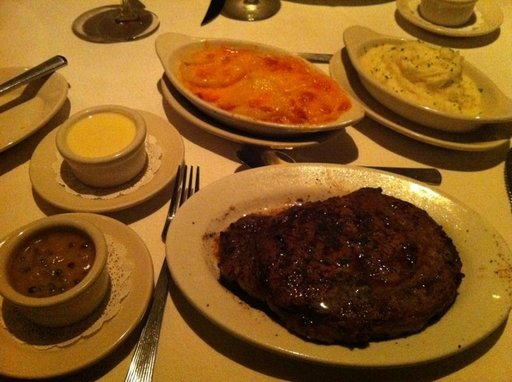

In [ ]:
# Get all image paths
images_paths = list(images_path.glob("*/*/*.jpg"))

random_image_path = random.choice(images_paths)
print("Image path:", random_image_path)

image_class = random_image_path.parent.stem # The name of the directory where the image is stored
print("Image class:", image_class)

img = PIL.Image.open(random_image_path)
print("Image height:",img.height)
print("Image width:", img.width)

img

- If we want to use the **matplotlib**, we have to convert the image to a numpy array.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

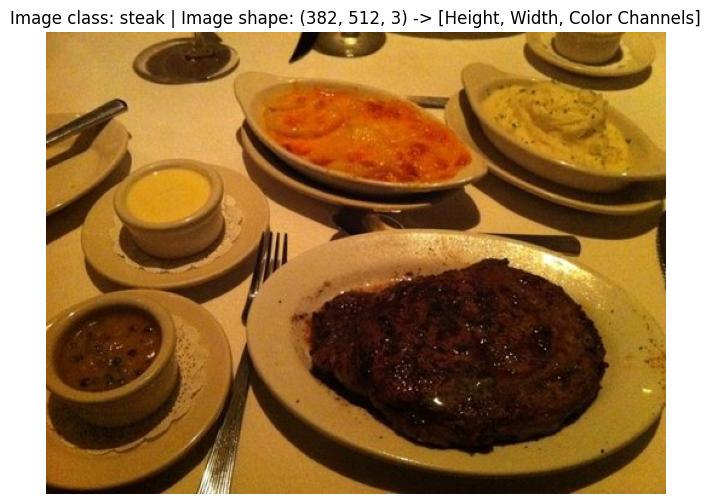

In [ ]:
img_to_array = np.asarray(img)
# print(img_to_array)

plt.figure(figsize = (10, 6))
plt.imshow(img_to_array)
plt.title(f"Image class: {image_class} | Image shape: {img_to_array.shape} -> [Height, Width, Color Channels]")
plt.axis(False);

## Data Transformation

- Turn your data into Tensors (numerical representation) to be able to load it into PyTorch.
-